In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Find database fields

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
meas_columns = inspector.get_columns('measurement')

for column in meas_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5;').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
stat_columns = inspector.get_columns('station')

for column in stat_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
engine.execute('SELECT * FROM station LIMIT 5;').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the latest date in the dataset
last_date_val = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date_val = dt.datetime.strptime(last_date_val, '%Y-%m-%d')

# Get the date value from 1 year prior to the last date
last_date_val = dt.date(last_date_val.year, last_date_val.month, last_date_val.day)
pyear_date_val = dt.date(last_date_val.year -1, last_date_val.month, last_date_val.day)

# Query the measurement table of the database using the date parameters
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=pyear_date_val).all()


# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
climate_data_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
climate_data_df.set_index('Date', inplace=True)
climate_data_df.dropna(how='any', inplace=True)
climate_data_df.sort_values(by='Date', ascending=True, inplace=True)
climate_data_df.head(3)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05


Text(0, 0.5, '\nAmount')

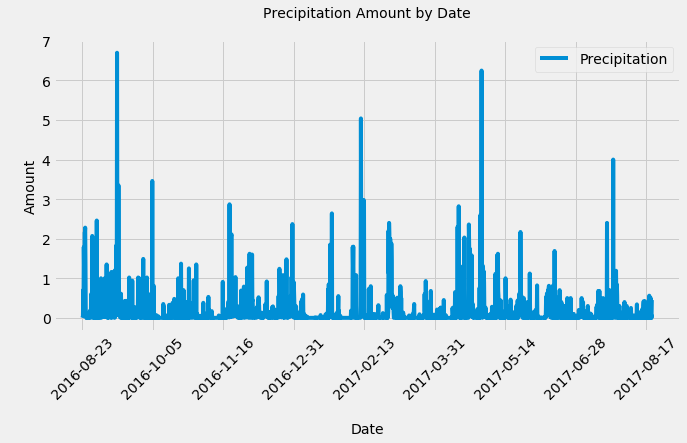

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = climate_data_df.plot(rot=45, figsize=(10,5))
plt.title('Precipitation Amount by Date\n', fontsize=14)
plt.xlabel('\nDate', fontsize=14)
plt.ylabel('\nAmount', fontsize=14)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
tot_stations = session.query(func.count(Station.id)).all()
print(f'There are a total of {tot_stations[0][0]} stations available in this dataset.')

There are a total of 9 stations available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station) \
                                .order_by(func.count(Measurement.station).desc()).all()
                                
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f'Recorded Temperatures: \n Lowest: {low_temp[0][0]} \n Highest: {high_temp[0][0]} \n Average: {avg_temp[0][0]}')

Recorded Temperatures: 
 Lowest: 54.0 
 Highest: 85.0 
 Average: 71.66378066378067


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_observations = session.query(Measurement.date, Measurement.tobs) \
                                 .filter(Measurement.station == 'USC00519281') \
                                 .filter(Measurement.date > pyear_date_val).all()
max_observations[0:3]

[('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0)]

In [22]:
max_observations_df = pd.DataFrame(max_observations)
max_observations_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


Text(0.5, 0, '\nTemperature (F)')

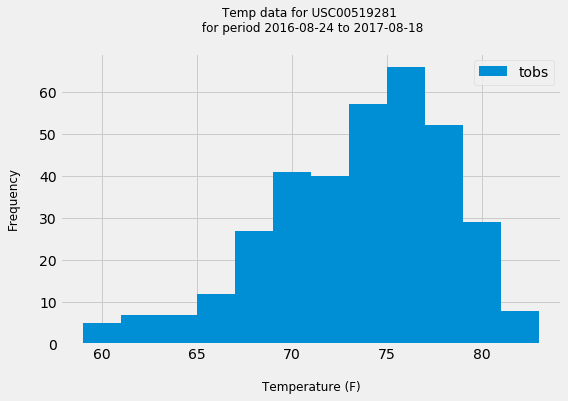

In [23]:
max_observations_df.plot(kind='hist', figsize=(8,5), bins=12)
min_date = max_observations_df['date'].min()
max_date = max_observations_df['date'].max()
plt.title(f'Temp data for USC00519281 \n for period {min_date} to {max_date}\n', fontsize=12)
plt.ylabel('Frequency\n', fontsize=12)
plt.xlabel('\nTemperature (F)', fontsize=12)